I needed to install ipympl to run this

In [1]:
%matplotlib widget
# from matplotlib.widgets import Button
import matplotlib.pyplot as plt
import mplcursors
import matplotlib.patches as patches

In [105]:
curr_id = 0
class Node:
    def __init__(self, x, y):
        global curr_id

        self.wage = 0
        self.wage_out = 0
        self.wage_in = 0
        self.coordinates = (x,y)
        self.edges_in = []
        self.edges_out = []
        self.id = curr_id
        curr_id += 1

    def __eq__(self, other: object) -> bool:
        if other == None:
            return False
        return self.coordinates[0] == other.coordinates[0] and self.coordinates[1] == other.coordinates[1]
    
    def __hash__(self) -> int:
        return hash(self.coordinates)
    
    def __repr__(self) -> str:
        return "id: " + str(self.id) + " (" + str(self.coordinates[0]) + ", " + str(self.coordinates[1]) + ")"
    
    def __str__(self) -> str:
        return self.__repr__()

class Edge:
    def __init__(self, node1, node2):
        self.node1 = node1
        self.node2 = node2
        self.wage = 1
        while node2.coordinates[0] == node1.coordinates[0]:
            node1.coordinates[0] += 10**-14
        self.a = (node2.coordinates[1] - node1.coordinates[1]) / (node2.coordinates[0] - node1.coordinates[0])
        self.b = (node1.coordinates[1] - self.a * node1.coordinates[0])
    
    def is_x_in_line(self, x):

        e = 10**-3
        x1 = self.node1.coordinates[0]
        x2 = self.node2.coordinates[0]

        return x < max(x1, x2) + e and x > min(x1, x2) - e

    def are_intersecting(self, other:object) -> bool:
        
        if self.a == other.a:
            return False
        
        inter_x = round((self.b - other.b) / (other.a - self.a),3)
        
        if (self.is_x_in_line(inter_x)
            and other.is_x_in_line(inter_x)
            and inter_x != self.node1.coordinates[0]
            and inter_x != other.node1.coordinates[0]
            and inter_x != self.node2.coordinates[0]
            and inter_x != other.node2.coordinates[0]):

            return True
        
        return False

    def __eq__(self, other: object) -> bool:
        if other == None:
            return False
        return self.node1 == other.node1 and self.node2 == other.node2
    
    def __hash__(self) -> int:
        return hash(self.node1, self.node2)
    
    def __repr__(self) -> str:
        return str(self.node1) + " -> " + str(self.node2)
    
    def __str__(self) -> str:
        return self.__repr__()


class Graph:
    def __init__(self, nodes=[]):
        self.nodes = nodes
        self.edges = []

    def add_edge(self, n1: Node, n2:Node) -> None:
        e = None
        if n1.coordinates[1] > n2.coordinates[1]:
            e = Edge(n2, n1)
        elif n1.coordinates[1] < n2.coordinates[1]:
            e = Edge(n1, n2)
        elif n1.coordinates[0] > n2.coordinates[0]:
            e = Edge(n1, n2)
        else:
            e = Edge(n2, n1)

        self.edges.append(e)
        e.node1.edges_out.append(e)
        e.node2.edges_in.append(e)


    def __repr__(self) -> str:
        return f'Graph contains {len(self.nodes)} nodes and {len(self.edges)} edges'
    
    def draw(self) -> tuple[plt.Figure, plt.Axes]:

        fig, ax = plt.subplots()
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)

        for node in self.nodes:
            x, y = node.coordinates
            ax.scatter(x, y, color='blue')

        for edge in self.edges:
            x1, y1 = edge.node1.coordinates
            x2, y2 = edge.node2.coordinates
            ax.plot([x1, x2], [y1, y2], color='green')

        return fig, ax

    def draw_with_arrows(self) -> tuple[plt.Figure, plt.Axes]:
        fig, ax = plt.subplots()
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)

        for node in self.nodes:
            x, y = node.coordinates
            ax.scatter(x, y, color='blue')

        for edge in self.edges:
            x1, y1 = edge.node1.coordinates
            x2, y2 = edge.node2.coordinates
            arrow = patches.FancyArrowPatch(edge.node1.coordinates, edge.node2.coordinates, color = "blue", arrowstyle='->', mutation_scale=15)
            ax.add_patch(arrow)

        return fig, ax

### creating polygon

In [106]:

def create_polygon():
    points = []
    nodes = []
    end = False

    def on_click(event):
        nonlocal click_cid, fig

        x, y = event.xdata, event.ydata
        if x is not None and y is not None:
            x = round(x, 3)
            y = round(y, 3)
            node = Node(x, y)
            nodes.append(node)
            points.append((x, y))

            if len(points)==1:
                plt.scatter(x, y, color='blue')
                plt.draw()

            # edges
            if len(points) > 1:
                if not is_end():
                    x_values = [points[-2][0], points[-1][0]]
                    y_values = [points[-2][1], points[-1][1]]
                    plt.scatter(x, y, color='blue')
                    plt.plot(x_values, y_values, color='blue')
                    plt.draw()
                elif is_end():
                    fig.canvas.mpl_disconnect(click_cid)
                    points.pop() # remove duplicate point
                    nodes.pop()
                    x_values = [points[-1][0], points[0][0]]
                    y_values = [points[-1][1], points[0][1]]
                    plt.plot(x_values, y_values, color = 'blue')
                    plt.draw()
                    


    def is_end():
        eps = 0.25
        first_point = points[0]
        last_point = points[-1]

        if abs(first_point[0] - last_point[0]) <= eps and abs(first_point[1] - last_point[1]) <= eps:
            return True
        return False

    fig, ax = plt.subplots()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    click_cid = fig.canvas.mpl_connect('button_press_event', on_click)

    mplcursors.cursor(hover=True)
    return nodes

#### Initial edges

In [75]:
def make_init_graph(nodes:list[Node]) -> Graph:
    def find_idx_highest_lowest(points):
        highest = max(nodes, key = lambda node: (node.coordinates[1], node.coordinates[0]))
        lowest = min(nodes, key = lambda node: (node.coordinates[1], node.coordinates[0]))

        return nodes.index(highest), nodes.index(lowest)
     

    if len(nodes)<3:
        print("Figure is not valid")
        raise ValueError
    
    highest_idx, lowest_idx = find_idx_highest_lowest(nodes)
    graph = Graph(nodes)
    nodes[highest_idx].chain = 1
    nodes[lowest_idx].chain = 0


    if highest_idx < lowest_idx:
        for i in range(highest_idx, lowest_idx):
            graph.add_edge(nodes[i+1], nodes[i])
            nodes[i].chain = 0

        for i in range(lowest_idx, len(nodes)-1):
            graph.add_edge(nodes[i], nodes[i+1])
            nodes[i].chain = 1

        graph.add_edge(nodes[-1], nodes[0])

        for i in range(0, highest_idx):
            graph.add_edge(nodes[i], nodes[i+1])
            nodes[i].chain = 1

    else:
        for i in range(lowest_idx, highest_idx):
            graph.add_edge(nodes[i], nodes[i+1])
            nodes[i].chain = 1
        
        for i in range(highest_idx, len(nodes)-1):
            graph.add_edge(nodes[i+1], nodes[i])
            nodes[i].chain = 0

        graph.add_edge(nodes[0], nodes[-1])

        for i in range(0, lowest_idx):
            graph.add_edge(nodes[i+1], nodes[i])
            nodes[i].chain = 0

        

    return graph

# notebookowy text

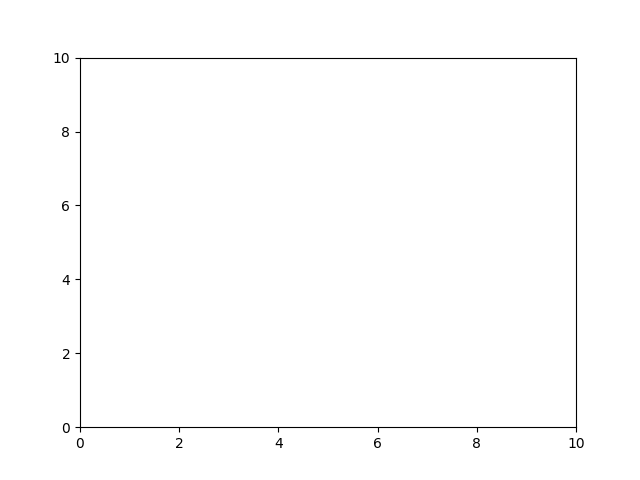

In [107]:
plt.close()
nodes = create_polygon()

Graph contains 7 nodes and 7 edges


(<Figure size 640x480 with 1 Axes>, <Axes: >)

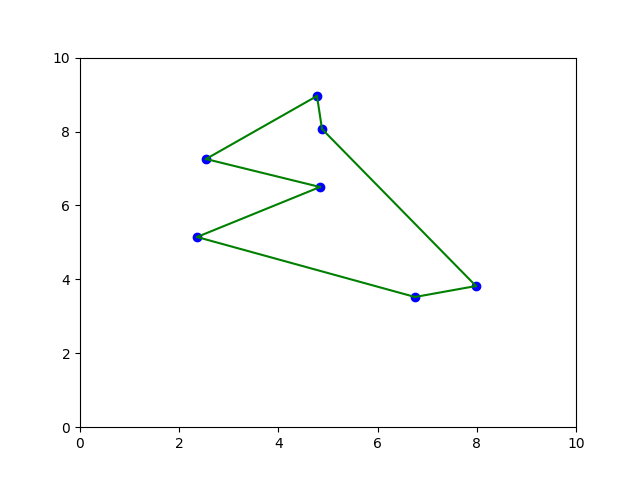

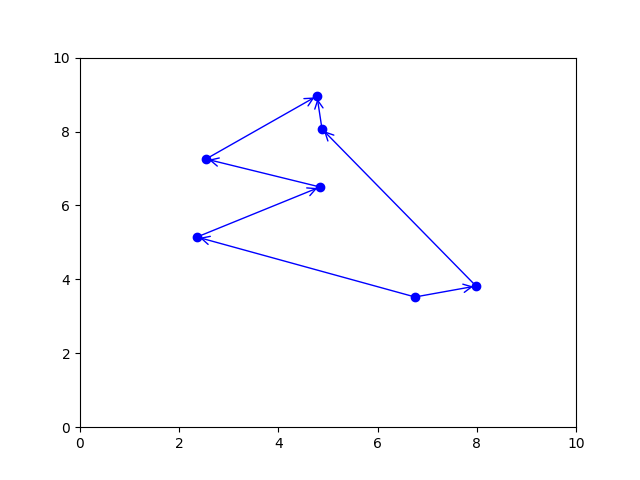

In [108]:
plt.close()
graph = make_init_graph(nodes)
print(graph)
graph.draw()
graph.draw_with_arrows()

In [109]:
class Interactive_graph:
    def __init__(self, graph:Graph) -> None:
        self.graph = graph
        self.active_node = None
        self.fig, self.ax = plt.subplots()
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.draw_graph()

    def on_click(self, event):
        if event.inaxes == self.ax:
            x, y = event.xdata, event.ydata
            clicked_node = self.get_clicked_node(x, y)

            # new connection
            if (self.active_node is not None 
                and clicked_node != self.active_node 
                and self.possible_connection(self.active_node, clicked_node)):
                self.graph.add_edge(self.active_node, clicked_node)
                self.draw_graph()
                return


            # new active_node
            if clicked_node is not None:
                if self.active_node == clicked_node:
                    # print(self.active_node.edges_in)
                    self.active_node = None
                else:
                    self.active_node = clicked_node

            self.draw_graph()

    def get_clicked_node(self, x, y, e = 0.25):
        for node in self.graph.nodes:
            if abs(node.coordinates[0] - x) < e and abs(node.coordinates[1] - y) < e:
                return node
        return None

    def draw_graph(self):
        self.ax.clear()
        
        size_of_points = 50

        self.ax.set_xlim(0, 10)
        self.ax.set_ylim(0, 10)

        for node in self.graph.nodes:
            x, y = node.coordinates

            if self.active_node is not None and node == self.active_node:
                self.ax.scatter(*self.active_node.coordinates, color = 'purple', s = size_of_points)
            elif self.active_node is not None:
                if self.possible_connection(self.active_node, node):
                    self.ax.scatter(x, y, color = 'green', s = size_of_points)
                else:
                    self.ax.scatter(x, y, color='red', s = size_of_points)
            else:
                self.ax.scatter(x, y, color='blue', s = size_of_points)

        for edge in self.graph.edges:
            x1, y1 = edge.node1.coordinates
            x2, y2 = edge.node2.coordinates
            self.ax.plot([x1, x2], [y1, y2], color='green')

        plt.draw()

    def possible_connection(self, an:Node, n2:Node) -> bool:
        # an = active_node

        e = 10**-3 

        if Edge(an, n2) in self.graph.edges or Edge(n2, an) in self.graph.edges:
            return False

        for edge in self.graph.edges:
            if edge.are_intersecting(Edge(an, n2)):
                return False
            
        return True


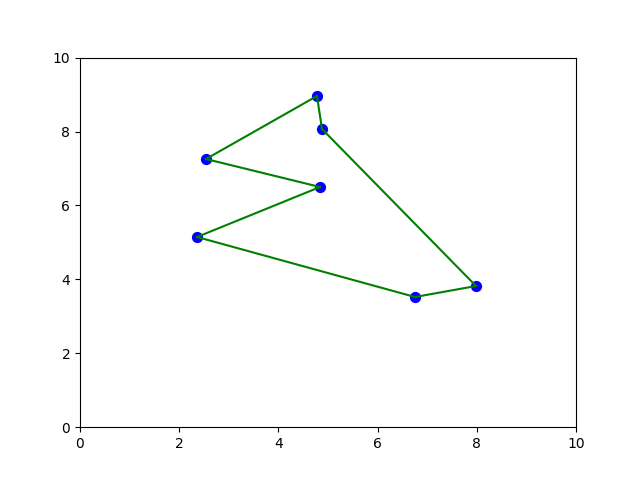

In [110]:
plt.close()

interactive = Interactive_graph(graph)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

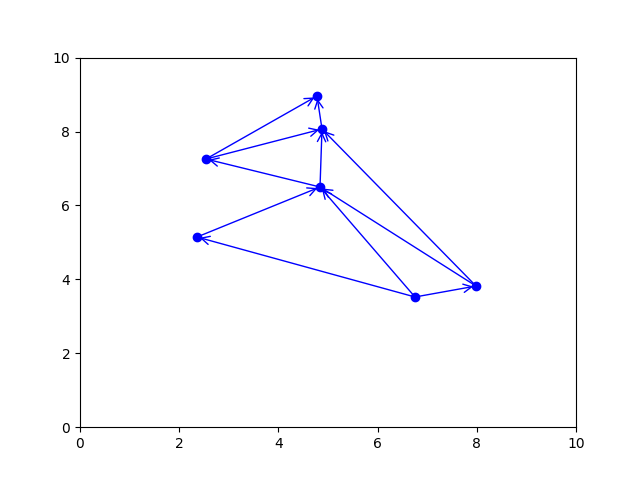

In [111]:
graph = interactive.graph
graph.draw_with_arrows()

In [120]:
def collect_point(graph):
    points = []

    def add_point(event):
        nonlocal points
        x = event.xdata
        y = event.ydata

        if x is not None and y is not None:
            points.append((x, y))
            ax.scatter(*points[-1])
            plt.draw()


    fig, ax = graph.draw()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Add point')

    click_cid = plt.gcf().canvas.mpl_connect('button_press_event', add_point)

    
    return points

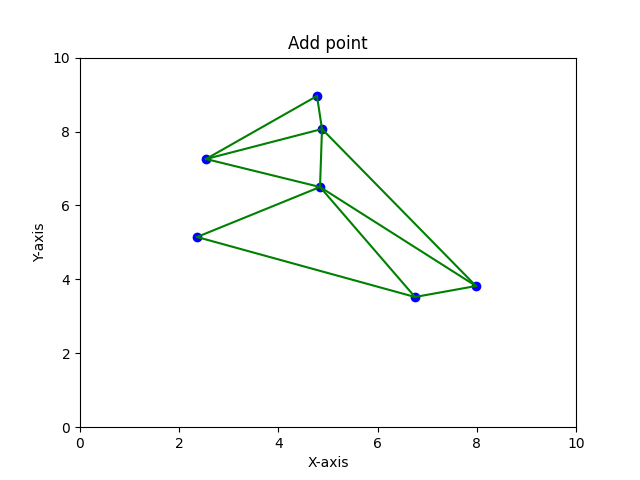

In [121]:
points = collect_point(graph)

In [124]:
point = points[-1] # only last clicked point will matter
print(point)

(5.907258064516128, 5.0649350649350655)


### Wyznaczanie wag krawedzi

In [25]:
def sort_from_left(v, edges):

    def a(a,b):
        return (a[1]-b[1])/(a[0]-b[0])
    
    def cmp(e):
        vcoordinates = v.coordinates
        if e.node2 != v:
            orient = a(vcoordinates, e.node2.coordinates)
            i = 1
        else:
            orient = a(vcoordinates, e.node1.coordinates)
            i = -1
        if orient < 0:
            return(-1*i,-orient*i)
        elif orient > 0:
            return(1*i,-orient*i)
        else:
            return(0)
    
    if len(edges) == 0:
        return None
    edges.sort(key = lambda e: cmp(e))
    return edges

In [26]:
def edgeswages(graph):
    nodes = graph.nodes
    nodes.sort(key=lambda x: (x.coordinates[1],x.coordinates[0]))
    for v in nodes:
        v.wage_in = 0
        for v_in in v.edges_in:
            v.wage_in += v_in.wage
        edges_sorted = sort_from_left(v, v.edges_out)
        if edges_sorted != None and  v.wage_in > len(v.edges_out):
            d = edges_sorted[0]
            d.wage += v.wage_in - len(v.edges_out)
    nodes.reverse()
    for v in nodes:
        v.wage_out = 0
        for v_out in v.edges_out:
            v.wage_out += v_out.wage
        edges_sorted = sort_from_left(v, v.edges_in)
        if edges_sorted != None and  v.wage_out > v.wage_in:
            d = edges_sorted[0]
            d.wage += v.wage_out - v.wage_in
    return

## Przykład do testów

In [29]:
n1 = Node(10,0)
n2 = Node(12,2)
n3 = Node(5,5)
n4 = Node(11,7)
n5 = Node(15,8)
n6 = Node(10,9)
n7 = Node(14,10)
n8 = Node(0,12)
n9 = Node(9,15)
nodes = [n1, n2, n3, n4, n5, n6, n7, n8, n9]

e1 = Edge(n1,n2)
e2 = Edge(n1,n3)
e3 = Edge(n1,n4)
e4 = Edge(n1,n5)
e5 = Edge(n2,n5)
e6 = Edge(n3,n4)
e7 = Edge(n3,n6)
e8 = Edge(n3,n8)
e9 = Edge(n4,n5)
e10 = Edge(n4,n6)
e11 = Edge(n5,n6)
e12 = Edge(n5,n7)
e13 = Edge(n6,n7)
e14 = Edge(n6,n9)
e15 = Edge(n7,n9)
e16 = Edge(n8,n9)
edges = [e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15, e16]

for e in edges:
    e.node1.edges_out.append(e)
    e.node2.edges_in.append(e)

graph = Graph()
graph.edges = edges
graph.nodes = nodes

In [ ]:
# edgeswages(graph)
# sorted = sort_from_left(n1, n1.edges_out)
# for edge in sorted:
#     print(edge.node2.coordinates)

In [ ]:
# for e in edges:
#     print(f"waga: {e.wage}, wierz: {e.node1.coordinates}, {e.node2.coordinates}")

### Wyznaczanie separatorów

In [30]:
def find_separators(graph):
    edgeswages(graph)
    nodes = graph.nodes
    nodes.sort(key=lambda x: (x.coordinates[1],x.coordinates[0]))
    separators = []

    def find(v, sep, v_k):
        if v == v_k:
            return sep
        if v.edges_out == None:
            return sep
        v.edges_out = sort_from_left(v,v.edges_out)
        i = 0
        while len(v.edges_out) > i and v.edges_out[i].wage == 0:
            i += 1
        if len(v.edges_out) <= i:
            return None
        v.edges_out[i].wage -=1
        sep.append(v.edges_out[i])
        return(find(v.edges_out[i].node2, sep, v_k))

    for v in range(0,len(nodes)-1):
        nodes[v].edges_out = sort_from_left(nodes[v], nodes[v].edges_out)
    separator = find(nodes[0],[], nodes[-1])
    while separator != None:
        separators.append(separator)
        separator = find(nodes[0],[], nodes[-1])
    return separators


In [31]:
separators = find_separators(graph)
for s in separators:
    for v in s:
        print(v.node2)
    print("\n")
print(len(separators))


id: 29 (5, 5)
id: 34 (0, 12)
id: 35 (9, 15)


id: 29 (5, 5)
id: 32 (10, 9)
id: 35 (9, 15)


id: 29 (5, 5)
id: 30 (11, 7)
id: 32 (10, 9)
id: 35 (9, 15)


id: 30 (11, 7)
id: 31 (15, 8)
id: 32 (10, 9)
id: 35 (9, 15)


id: 31 (15, 8)
id: 32 (10, 9)
id: 33 (14, 10)
id: 35 (9, 15)


id: 28 (12, 2)
id: 31 (15, 8)
id: 33 (14, 10)
id: 35 (9, 15)


6


### Drzewo Binarne przechowujące separatory

In [26]:
class TreeNode:
    def __init__(self, edges, id, parent):
        self.id = id
        self.parent = parent
        self.right = None
        self.left = None
        self.edges=edges

In [27]:
def make_Tree(separators):

    # Zamień used na hashmape!!
    # Optymalizacja by nie pamietac wszystkich krawedzi

    def delete_used(separatorEdges, used):
        i=0
        while i < len(separatorEdges):
            if separatorEdges[i] in used:
                separatorEdges.pop(i)
            else:
                used.append(separatorEdges[i])
                i += 1
        return separatorEdges, used
    
    def create(start, stop, used, parent):
        if stop-start == 0:
            return None
        sr = (stop+start)//2
        print(sr)
        new_edges, used = delete_used(separators[sr], used)
        new = TreeNode(new_edges, sr, parent)
        new.left = create(start, sr, used, new)
        new.right = create(sr+1,stop, used, new)
        return new
    
    print(len(separators))
    top = create(0, len(separators), [], None)
    return top


In [28]:
top = make_Tree(separators)

6
3
1
0
2
5
4


In [29]:
def print_Tree(top):
    print(top.id)
    if top.left != None:
        print_Tree(top.left)
    if top.right != None:
        print_Tree(top.right)
    return

In [30]:
print_Tree(top)

3
1
0
2
5
4


### Lokalizacja punktu

In [31]:
def Orientation(a, b, c):
    temp1 = a[0] * b[1] - c[0] * b[1]
    temp2 = b[0] * c[1] - c[1] * a[0]
    temp3 = a[1] * c[0] - a[1] * b[0]
    return temp1 + temp2 + temp3


def right_left(point, edge):
    orient = Orientation(edge.node1.coordinates, edge.node2.coordinates, point)
    return orient


In [33]:
def localize_point(point, top, last):
    separator = top.edges
    i = 0
    while len(separator) > i and separator[i].node2.coordinates[1] < point[1]:
        i += 1
    if i >= len(separator):
        orient = last
    else:
        orient = right_left(point, separator[i])
    if  orient < 0:
        if top.right == None:
            return (top.id + 1, top.id+2)
        else:
            return localize_point(point, top.right, -1)
    else:
        if top.left == None:
            return (top.id, top.id+1)
        else:
            return localize_point(point, top.left, 1)
    

In [34]:
# p = [12,11]
p = [5,10]
location = localize_point(p, top, None)
print(location)

NameError: name 'top' is not defined

In [ ]:
### Krawedzie otaczające obszar na którym znajduje się punkt
edges_upper = separators[location[0]-1]
edges_lower = separators[location[1]-1]